# Transform New York Taxi Dataset into Time Series Dataset
There are four taxi types with different length time in New York City (2009-2023).
1. Yellow Taxi with data range from January 1st 2009 until September 30th 2023.
2. Green Taxi with data range from  January 1st 2014 until September 30th 2023.
3. For Hire Vehicle with data range from  January 1st 2015 until September 30th 2023.
4. High Volume For Hire Vehicle with data range from  January 1st 2019 until September 30th 2023.

Each trip data was recorded and the daily data aggregation is required to create time series data for each type of taxi. There are 7 columns will be selected for data analysis, which are:
1. pick_up_time is the time passenger enter the taxi
2. drop_off_time is the time passenger get out from taxi
3. passenger_count is the number of passenger
4. trip_distance is the length of the trip
5. payment_type is the type of payment
6. total_amount is the total amount of charge for the trip
7. tip_amount is the amount of tips given by passenger

With these columns data, the data pipeline is as follow:
1. Select those 7 columns from their original tables
2. Change their column name into stardard column name
3. Delete rows data that contain NULL
4. Filter data in the range of January 1st 2009 until September 30th 2023

Then do aggregation for time series data
1. Find the number of daily/monthly trips for each taxi provider.
2. Find the average distance of each trip
3. Find the average of duration for each trip
4. Calculate percentage of tips compare to total amount paid


In [1]:
import polars as pl
import duckdb
import matplotlib.pyplot as plt

In [2]:
# Find out the total row of data
query_row_data = """ 
SELECT count(*) AS total_rows
FROM (
    SELECT 1 FROM read_parquet('C:/Users/ekadw/Documents/DATA/NY_Taxi/*/yellow_taxi_*/yellow_tripdata_*.parquet')
    UNION ALL
    SELECT 1 FROM read_parquet('C:/Users/ekadw/Documents/DATA/NY_Taxi/*/yellow_taxi/yellow_tripdata_*.parquet')
    UNION ALL
    SELECT 1 FROM read_parquet('C:/Users/ekadw/Documents/DATA/NY_Taxi/*/green_taxi/green_tripdata_*.parquet')
    UNION ALL
    SELECT 1 FROM read_parquet('C:/Users/ekadw/Documents/DATA/NY_Taxi/*/for_hire_vehicle/fhv_tripdata_*.parquet')
    UNION ALL
    SELECT 1 FROM read_parquet('C:/Users/ekadw/Documents/DATA/NY_Taxi/*/high_volume_for_hire_vehicle/fhvhv_tripdata_*.parquet')
)
"""
con = duckdb.connect()
df_row_data = con.execute(query_row_data).fetchdf()
df_row_data.head()

,total_rows
0,3494451597


It is almost 3.5 billions rows of data.

## 1. Yellow Taxi
Unfortunately the name of column headers for yellow taxi are not the same. There will be a different in giving name title. For that reason, the column name must be standardized.

### 1.1 The 2009 Yellow Taxi Data
The column name will be changed as follow:
1. Trip_Pickup_DateTime is replaced by pick_up_time
2. Trip_Dropoff_DateTime is replaced by drop_off_time
3. Passenger_Count is replaced by passenger_count
4. Trip_Distance is replaced by trip_distance
5. Payment_Type is replaced by payment_type
6. Total_Amt is replaced by total_amount
7. Tip_Amt is replaced by tip_amount

In [3]:
#--- Read the 2009 Yellow Taxi dataset then look fer the first 5 rows ---
yellow_2009 = pl.read_parquet(r"C:\Users\ekadw\Documents\DATA\NY_Taxi\2009\yellow_taxi_2009\yellow_tripdata_2009-01.parquet")
yellow_2009.head()

vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt
str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64
"""VTS""","""2009-01-04 02:52:00""","""2009-01-04 03:02:00""",1,2.63,-73.991957,40.721567,null,null,-73.993803,40.695922,"""CASH""",8.9,0.5,null,0.0,0.0,9.4
"""VTS""","""2009-01-04 03:31:00""","""2009-01-04 03:38:00""",3,4.55,-73.982102,40.73629,null,null,-73.95585,40.76803,"""Credit""",12.1,0.5,null,2.0,0.0,14.6
"""VTS""","""2009-01-03 15:43:00""","""2009-01-03 15:57:00""",5,10.35,-74.002587,40.739748,null,null,-73.869983,40.770225,"""Credit""",23.7,0.0,null,4.74,0.0,28.44
"""DDS""","""2009-01-01 20:52:58""","""2009-01-01 21:14:00""",1,5.0,-73.974267,40.790955,null,null,-73.996558,40.731849,"""CREDIT""",14.9,0.5,null,3.05,0.0,18.45
"""DDS""","""2009-01-24 16:18:23""","""2009-01-24 16:24:56""",1,0.4,-74.00158,40.719382,null,null,-74.008378,40.72035,"""CASH""",3.7,0.0,null,0.0,0.0,3.7


In [4]:
#--- Find out all the columns name ---
yellow_2009.columns

['vendor_name',
 'Trip_Pickup_DateTime',
 'Trip_Dropoff_DateTime',
 'Passenger_Count',
 'Trip_Distance',
 'Start_Lon',
 'Start_Lat',
 'Rate_Code',
 'store_and_forward',
 'End_Lon',
 'End_Lat',
 'Payment_Type',
 'Fare_Amt',
 'surcharge',
 'mta_tax',
 'Tip_Amt',
 'Tolls_Amt',
 'Total_Amt']

### 1.2 The 2010 Yellow Taxi Data
The column name will be changed as follow:
1. pickup_datetime is replaced by pick_up_time
2. dropoff_datetime is replaced by drop_off_time
3. passenger_count is the same
4. trip_distance is the same
5. payment_type is the same
6. total_amount is the same
7. tip_amount is the same

In [5]:
#--- Read the 2010 Yellow Taxi dataset then look fer the first 5 rows ---
yellow_2010 = pl.read_parquet(r"C:\Users\ekadw\Documents\DATA\NY_Taxi\2010\yellow_taxi_2010\yellow_tripdata_2010-01.parquet")
yellow_2010.head()

vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
str,str,str,i64,f64,f64,f64,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64
"""VTS""","""2010-01-26 07:41:00""","""2010-01-26 07:45:00""",1,0.75,-73.956778,40.76775,"""1""",null,-73.965957,40.765232,"""CAS""",4.5,0.0,0.5,0.0,0.0,5.0
"""DDS""","""2010-01-30 23:31:00""","""2010-01-30 23:46:12""",1,5.9,-73.996118,40.763932,"""1""",null,-73.981512,40.741193,"""CAS""",15.3,0.5,0.5,0.0,0.0,16.3
"""DDS""","""2010-01-18 20:22:20""","""2010-01-18 20:38:12""",1,4.0,-73.979673,40.78379,"""1""",null,-73.917852,40.87856,"""CAS""",11.7,0.5,0.5,0.0,0.0,12.7
"""VTS""","""2010-01-09 01:18:00""","""2010-01-09 01:35:00""",2,4.7,-73.977922,40.763997,"""1""",null,-73.923908,40.759725,"""CAS""",13.3,0.5,0.5,0.0,0.0,14.3
"""CMT""","""2010-01-18 19:10:14""","""2010-01-18 19:17:07""",1,0.6,-73.990924,40.734682,"""1""","""0""",-73.995511,40.739088,"""Cre""",5.3,0.0,0.5,0.87,0.0,6.67


In [6]:
#--- Find out all the columns name ---
yellow_2010.columns

['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'rate_code',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'surcharge',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'total_amount']

### 1.3 Yellow Taxi Data from 2011 until 2023
The column name will be changed as follow:
1. tpep_pickup_datetime is replaced by pick_up_time
2. tpep_dropoff_datetime is replaced by drop_off_time
3. passenger_count is the same
4. trip_distance is the same
5. payment_type is the same
6. total_amount is the same
7. tip_amount is the same

In [7]:
#--- Read the 2011-2023 Yellow Taxi dataset then look fer the first 5 rows ---
yellow_2011_2023 = pl.read_parquet(r"C:\Users\ekadw\Documents\DATA\NY_Taxi\2022\yellow_taxi\yellow_tripdata_2022-01.parquet")
yellow_2011_2023.head()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i64,datetime[ns],datetime[ns],f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,"""N""",142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,"""N""",236,42,1,8.0,0.5,0.5,4.0,0.0,0.3,13.3,0.0,0.0
2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,"""N""",166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,"""N""",114,68,2,8.0,0.5,0.5,0.0,0.0,0.3,11.8,2.5,0.0
2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.3,1.0,"""N""",68,163,1,23.5,0.5,0.5,3.0,0.0,0.3,30.3,2.5,0.0


In [8]:
#--- Find out all the columns name ---
yellow_2011_2023.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

### 1.4 Find the Number of Daily Trip from Yellow Taxi
The command COUNT() will be used to find out the number of daily trip.

In [9]:
query_yellow_count = """
WITH CTE_2009 AS (
    SELECT 
        Trip_Pickup_DateTime AS pick_up_time,
        Trip_Dropoff_DateTime AS drop_off_time,
        Passenger_Count AS passenger_count,
        Trip_Distance AS trip_distance,
        Payment_Type AS payment_type,
        Total_Amt AS total_amount,
        Tip_Amt AS tip_amount
    FROM 'C:/Users/ekadw/Documents/DATA/NY_Taxi/2009/yellow_taxi_2009/yellow_tripdata_*.parquet'
    WHERE Trip_Pickup_DateTime IS NOT NULL
        AND Trip_Dropoff_DateTime IS NOT NULL
        AND Passenger_Count IS NOT NULL
        AND Trip_Distance IS NOT NULL
        AND Payment_Type IS NOT NULL
        AND Total_Amt IS NOT NULL
        AND Tip_Amt IS NOT NULL
        AND Trip_Pickup_DateTime >= '2009-01-01' 
        AND Trip_Pickup_DateTime < '2010-10-01'
), CTE_2010 AS (
    SELECT 
        pickup_datetime AS pick_up_time,
        dropoff_datetime AS drop_off_time,
        passenger_count,
        trip_distance,
        payment_type,
        total_amount,
        tip_amount
    FROM 'C:/Users/ekadw/Documents/DATA/NY_Taxi/2010/yellow_taxi_2010/yellow_tripdata_*.parquet'
    WHERE pickup_datetime IS NOT NULL
        AND dropoff_datetime IS NOT NULL
        AND passenger_count IS NOT NULL
        AND trip_distance IS NOT NULL
        AND payment_type IS NOT NULL
        AND total_amount IS NOT NULL
        AND tip_amount IS NOT NULL
        AND pickup_datetime >= '2010-01-01' 
        AND pickup_datetime < '2011-01-01'
), CTE_2011_2023 AS (
    SELECT 
        tpep_pickup_datetime AS pick_up_time,
        tpep_dropoff_datetime AS drop_off_time,
        passenger_count,
        trip_distance,
        payment_type,
        total_amount,
        tip_amount
    FROM 'C:/Users/ekadw/Documents/DATA/NY_Taxi/*/yellow_taxi/yellow_tripdata_*.parquet'
    WHERE tpep_pickup_datetime IS NOT NULL
        AND tpep_dropoff_datetime IS NOT NULL
        AND passenger_count IS NOT NULL
        AND trip_distance IS NOT NULL
        AND payment_type IS NOT NULL
        AND total_amount IS NOT NULL
        AND tip_amount IS NOT NULL
        AND tpep_pickup_datetime >= '2011-01-01' 
        AND tpep_dropoff_datetime < '2023-10-01'
), CTE_union_2009_2023 AS (
    SELECT * FROM CTE_2009
    UNION ALL
    SELECT * FROM CTE_2010
    UNION ALL
    SELECT * FROM CTE_2011_2023
), CTE_count_trip AS (
    SELECT
        DATE(pick_up_time) AS pick_up_date
    FROM CTE_union_2009_2023
)

SELECT 
    pick_up_date AS day_of_trip,
    COUNT(*) AS total_trip
FROM CTE_count_trip
GROUP BY pick_up_date
ORDER BY pick_up_date 
"""

con = duckdb.connect()
df_yellow_count = con.execute(query_yellow_count).fetchdf()
df_yellow_count.head()

,day_of_trip,total_trip
0,2009-01-01,327625
1,2009-01-02,376708
2,2009-01-03,432710
3,2009-01-04,367525
4,2009-01-05,370901


In [10]:
#--- Check the 10 last data
df_yellow_count.tail(10)

,day_of_trip,total_trip
5376,2023-09-21,37282
5377,2023-09-22,20
5378,2023-09-23,18
5379,2023-09-24,125
5380,2023-09-25,87644
5381,2023-09-26,107736
5382,2023-09-27,114350
5383,2023-09-28,121502
5384,2023-09-29,95916
5385,2023-09-30,106804


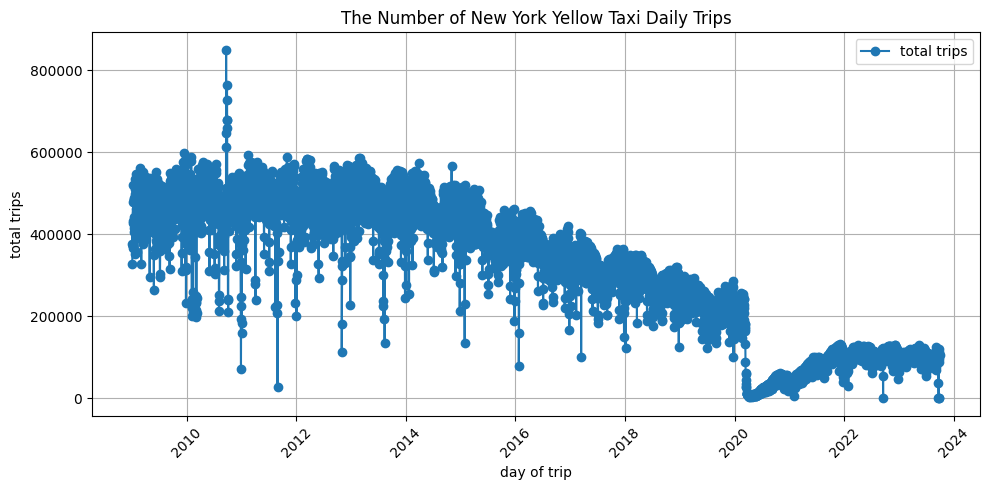

In [11]:
# Plotting Yellow Taxi from 2009-2023
# Ensure date is datetime
import pandas as pd 
df_yellow_count["day_of_trip"] = pd.to_datetime(df_yellow_count["day_of_trip"])

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_yellow_count["day_of_trip"], df_yellow_count["total_trip"], marker="o", linestyle="-", label="total trips")

plt.title("The Number of New York Yellow Taxi Daily Trips")
plt.xlabel("day of trip")
plt.ylabel("total trips")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The trend is decreasing. The biggest drop was during the covid pandemic. The daily data is too dense. Let make it to be monthly data then compare it with other taxi providers.

## 2. Green Taxi

In [12]:
#--- Check the Green Taxi dataset ---
green_2014 = pl.read_parquet(r"C:\Users\ekadw\Documents\DATA\NY_Taxi\2014\green_taxi\green_tripdata_2014-01.parquet")
green_2014.head()

VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
i64,datetime[ns],datetime[ns],str,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,null,f64,f64,i64,f64,null
2,2014-01-01 00:17:26,2014-01-01 00:37:11,"""N""",1,17,225,1,2.28,13.5,0.5,0.5,0.0,0.0,null,null,14.5,2,null,null
1,2014-01-01 00:29:12,2014-01-01 00:37:43,"""N""",1,127,241,1,2.1,9.0,0.0,0.5,0.0,0.0,null,null,9.5,2,null,null
2,2014-01-01 00:31:35,2014-01-01 00:44:09,"""N""",1,166,243,1,4.72,15.5,0.5,0.5,4.0,0.0,null,null,20.5,1,null,null
2,2014-01-01 00:07:01,2014-01-01 00:21:54,"""N""",1,7,157,1,2.88,13.0,0.5,0.5,2.88,0.0,null,null,16.88,1,null,null
2,2014-01-01 00:26:43,2014-01-01 00:37:17,"""N""",1,83,197,2,3.8,13.0,0.5,0.5,0.0,0.0,null,null,14.0,2,null,null


In [13]:
green_2014.columns

['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'ehail_fee',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge']

In [14]:
query_green_count = """
WITH CTE_green_2014_2023 AS (
    SELECT 
        lpep_pickup_datetime AS pick_up_time,
        lpep_dropoff_datetime AS drop_off_time,
        passenger_count,
        trip_distance,
        payment_type,
        total_amount,
        tip_amount
    FROM 'C:/Users/ekadw/Documents/DATA/NY_Taxi/*/green_taxi/green_tripdata_*.parquet'
    WHERE lpep_pickup_datetime IS NOT NULL
        AND lpep_dropoff_datetime IS NOT NULL
        AND passenger_count IS NOT NULL
        AND trip_distance IS NOT NULL
        AND payment_type IS NOT NULL
        AND total_amount IS NOT NULL
        AND tip_amount IS NOT NULL
        AND lpep_pickup_datetime >= '2014-01-01' 
        AND lpep_pickup_datetime < '2023-10-01'
), CTE_count_trip AS (
    SELECT
        DATE(pick_up_time) AS pick_up_date
    FROM CTE_green_2014_2023
)

SELECT 
    pick_up_date AS day_of_trip,
    COUNT(*) AS total_trip
FROM CTE_count_trip
GROUP BY pick_up_date
ORDER BY pick_up_date 
"""

con = duckdb.connect()
df_green_count = con.execute(query_green_count).fetchdf()
df_green_count.head()

,day_of_trip,total_trip
0,2014-01-01,25616
1,2014-01-02,19061
2,2014-01-03,13436
3,2014-01-04,23697
4,2014-01-05,20560


In [15]:
#--- Check the 10 last data
df_green_count.tail(10)

,day_of_trip,total_trip
3550,2023-09-21,2275
3551,2023-09-22,2097
3552,2023-09-23,1565
3553,2023-09-24,1433
3554,2023-09-25,1716
3555,2023-09-26,2145
3556,2023-09-27,2174
3557,2023-09-28,2362
3558,2023-09-29,1694
3559,2023-09-30,1658


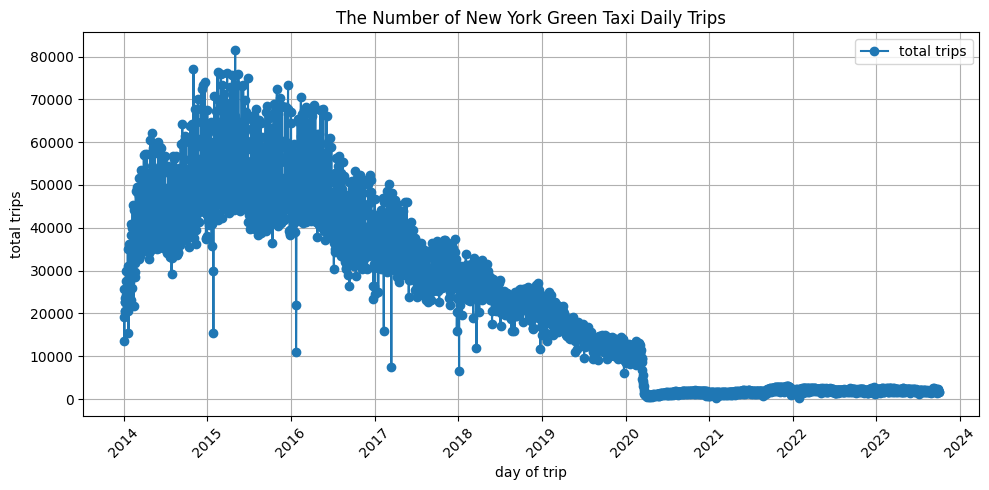

In [16]:
# Plotting Green Taxi from 2009-2023
# Ensure date is datetime
import pandas as pd 
df_green_count["day_of_trip"] = pd.to_datetime(df_green_count["day_of_trip"])

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_green_count["day_of_trip"], df_green_count["total_trip"], marker="o", linestyle="-", label="total trips")

plt.title("The Number of New York Green Taxi Daily Trips")
plt.xlabel("day of trip")
plt.ylabel("total trips")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

After the peak of daily number of trips in 2015-2016, there was a down pattern with steep decline jump during the pandemic and has not recovered until 2023.

# 3. High Volume For Hire Vehicle

In [17]:
#--- Check the High Volume for Hire Vehicle dataset ---
hvfhv_2019 = pl.read_parquet(r"C:\Users\ekadw\Documents\DATA\NY_Taxi\2019\high_volume_for_hire_vehicle\fhvhv_tripdata_2019-02.parquet")
hvfhv_2019.head()

hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
str,str,str,datetime[ns],datetime[ns],datetime[ns],datetime[ns],i64,i64,f64,i64,f64,f64,f64,f64,f64,null,f64,f64,str,str,str,str,null
"""HV0003""","""B02867""","""B02867""",2019-02-01 00:01:26,2019-02-01 00:02:55,2019-02-01 00:05:18,2019-02-01 00:14:57,245,251,2.45,579,9.35,0.0,0.23,0.83,0.0,null,0.0,7.48,"""Y""","""N""","""N""","""N""",null
"""HV0003""","""B02879""","""B02879""",2019-02-01 00:26:08,2019-02-01 00:41:29,2019-02-01 00:41:29,2019-02-01 00:49:39,216,197,1.71,490,7.91,0.0,0.2,0.7,0.0,null,2.0,7.93,"""N""","""N""","""N""","""N""",null
"""HV0005""","""B02510""",null,2019-02-01 00:48:58,null,2019-02-01 00:51:34,2019-02-01 01:28:29,261,234,5.01,2159,44.96,0.0,1.12,3.99,0.0,null,0.0,35.97,"""N""","""Y""","""N""","""N""",null
"""HV0005""","""B02510""",null,2019-02-01 00:02:15,null,2019-02-01 00:03:51,2019-02-01 00:07:16,87,87,0.34,179,7.19,0.0,0.18,0.64,0.0,null,3.0,5.39,"""N""","""Y""","""N""","""N""",null
"""HV0005""","""B02510""",null,2019-02-01 00:06:17,null,2019-02-01 00:09:44,2019-02-01 00:39:56,87,198,6.84,1799,24.25,0.11,0.61,2.16,0.0,null,4.0,17.07,"""N""","""Y""","""N""","""N""",null


In [18]:
#--- Find all the columns name ---
hvfhv_2019.columns

['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag']

In [19]:
#--- Create query for High Volume for Hire Vehicle from 2019-2023 ---
query_hvfhv_count = """
WITH CTE_hvfhv_2019_2023 AS (
    SELECT 
        pickup_datetime AS pick_up_time,
        dropoff_datetime AS drop_off_time,
        trip_miles AS trip_distance,
        tips AS tip_amount
    FROM 'C:/Users/ekadw/Documents/DATA/NY_Taxi/*/high_volume_for_hire_vehicle/fhvhv_tripdata_*.parquet'
    WHERE pickup_datetime IS NOT NULL
        AND dropoff_datetime IS NOT NULL
        AND trip_miles IS NOT NULL
        AND tips IS NOT NULL
        AND pickup_datetime >= '2019-01-01' 
        AND pickup_datetime < '2023-10-01'
), CTE_count_trip AS (
    SELECT
        DATE(pick_up_time) AS pick_up_date
    FROM CTE_hvfhv_2019_2023
)

SELECT 
    pick_up_date AS day_of_trip,
    COUNT(*) AS total_trip
FROM CTE_count_trip
GROUP BY pick_up_date
ORDER BY pick_up_date 
"""

con = duckdb.connect()
df_hvfhv_count = con.execute(query_hvfhv_count).fetchdf()
df_hvfhv_count.head()

,day_of_trip,total_trip
0,2019-02-01,860161
1,2019-02-02,866393
2,2019-02-03,756721
3,2019-02-04,592170
4,2019-02-05,576476


In [20]:
#--- Find the 10 last rows of data ---
df_hvfhv_count.tail(10)

,day_of_trip,total_trip
1693,2023-09-21,629723
1694,2023-09-22,699629
1695,2023-09-23,826773
1696,2023-09-24,679708
1697,2023-09-25,562116
1698,2023-09-26,601904
1699,2023-09-27,598360
1700,2023-09-28,678407
1701,2023-09-29,772654
1702,2023-09-30,733193


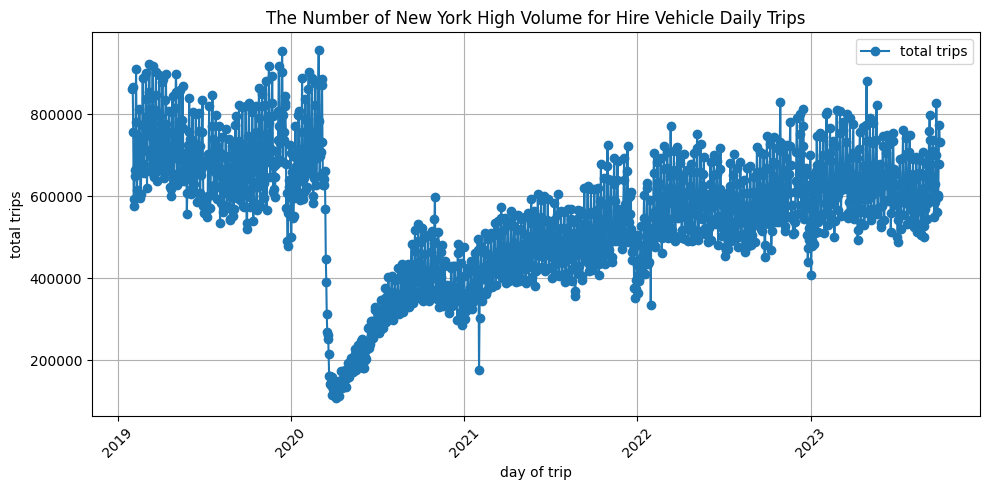

In [21]:
# Plotting High Volume for Hire Vehicle from 2019-2023
# Ensure date is datetime
import pandas as pd 
df_hvfhv_count["day_of_trip"] = pd.to_datetime(df_hvfhv_count["day_of_trip"])

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_hvfhv_count["day_of_trip"], df_hvfhv_count["total_trip"], marker="o", linestyle="-", label="total trips")

plt.title("The Number of New York High Volume for Hire Vehicle Daily Trips")
plt.xlabel("day of trip")
plt.ylabel("total trips")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

After deep decline at the early pandemic, it ha started to increase steadily compare to the previous two providers.

# 4. For Hire Vehicle

In [22]:
#--- Check the For Hire Vehicle dataset ---
fhv_2015 = pl.read_parquet(r"C:\Users\ekadw\Documents\DATA\NY_Taxi\2015\for_hire_vehicle\fhv_tripdata_2015-01.parquet")
fhv_2015.head()

dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
str,datetime[ns],datetime[ns],f64,f64,null,str
"""B00013""",2015-01-01 00:30:00,1989-01-01 00:00:00,null,null,null,"""B00013"""
"""B00014""",2015-01-01 00:28:00,1989-01-01 00:00:00,null,null,null,"""B00014"""
"""B00014""",2015-01-01 00:25:00,1989-01-01 00:00:00,null,null,null,"""B00014"""
"""B00014""",2015-01-01 00:13:00,1989-01-01 00:00:00,null,null,null,"""B00014"""
"""B00014""",2015-01-01 00:20:00,1989-01-01 00:00:00,null,null,null,"""B00014"""


In [23]:
fhv_2015.columns

['dispatching_base_num',
 'pickup_datetime',
 'dropOff_datetime',
 'PUlocationID',
 'DOlocationID',
 'SR_Flag',
 'Affiliated_base_number']

In [24]:
#--- Create query For Hire Vehicle from 2015-2023 ---
query_fhv_count = """
WITH CTE_fhv_2015_2023 AS (
    SELECT 
        pickup_datetime AS pick_up_time,
        dropOff_datetime AS drop_off_time
    FROM 'C:/Users/ekadw/Documents/DATA/NY_Taxi/*/for_hire_vehicle/fhv_tripdata_*.parquet'
    WHERE pickup_datetime IS NOT NULL
        AND dropOff_datetime IS NOT NULL
        AND pickup_datetime >= '2015-01-01' 
        AND pickup_datetime < '2023-10-01'
), CTE_count_trip AS (
    SELECT
        DATE(pick_up_time) AS pick_up_date
    FROM CTE_fhv_2015_2023
)

SELECT 
    pick_up_date AS day_of_trip,
    COUNT(*) AS total_trip
FROM CTE_count_trip
GROUP BY pick_up_date
ORDER BY pick_up_date 
"""

con = duckdb.connect()
df_fhv_count = con.execute(query_fhv_count).fetchdf()
df_fhv_count.head()

,day_of_trip,total_trip
0,2015-01-01,74620
1,2015-01-02,61560
2,2015-01-03,81496
3,2015-01-04,62365
4,2015-01-05,70595


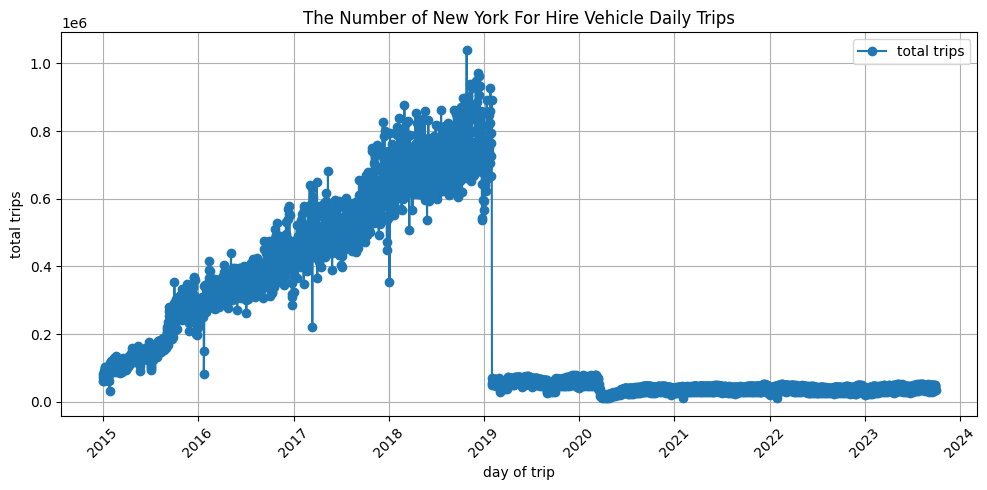

In [25]:
#--- Plotting High Volume for Hire Vehicle from 2019-2023---
# Ensure date is datetime
import pandas as pd 
df_fhv_count["day_of_trip"] = pd.to_datetime(df_fhv_count["day_of_trip"])

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_fhv_count["day_of_trip"], df_fhv_count["total_trip"], marker="o", linestyle="-", label="total trips")

plt.title("The Number of New York For Hire Vehicle Daily Trips")
plt.xlabel("day of trip")
plt.ylabel("total trips")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It was a steep increase before the pandemic and a sudden sharp decline in the start of pandemic. Since then it was a strugle to recover compare to before the pandemic hit.

# 5. Total Daily Taxi Trip in New York City

In [26]:
df_yellow_count.rename(columns={"total_trip": "total_trip_yellow"}, inplace=True)
df_green_count.rename(columns={"total_trip": "total_trip_green"}, inplace=True)
df_fhv_count.rename(columns={"total_trip": "total_trip_fhv"}, inplace=True)
df_hvfhv_count.rename(columns={"total_trip": "total_trip_hvfhv"}, inplace=True)

from functools import reduce

# Collect all dataframes
data_frames = [df_yellow_count, df_green_count, df_fhv_count, df_hvfhv_count]

# merge all on 'day_of_trip'
data_total = reduce(lambda left, right: pd.merge(left, right, on="day_of_trip", how="outer"), data_frames)

# compute total trip from four providers
data_total["total_trip"] = data_total.drop(columns=["day_of_trip"]).sum(axis=1, skipna=True)

data_total.head()

,day_of_trip,total_trip_yellow,total_trip_green,total_trip_fhv,total_trip_hvfhv,total_trip
0,2009-01-01,327625,NaN,NaN,NaN,327625.0
1,2009-01-02,376708,NaN,NaN,NaN,376708.0
2,2009-01-03,432710,NaN,NaN,NaN,432710.0
3,2009-01-04,367525,NaN,NaN,NaN,367525.0
4,2009-01-05,370901,NaN,NaN,NaN,370901.0


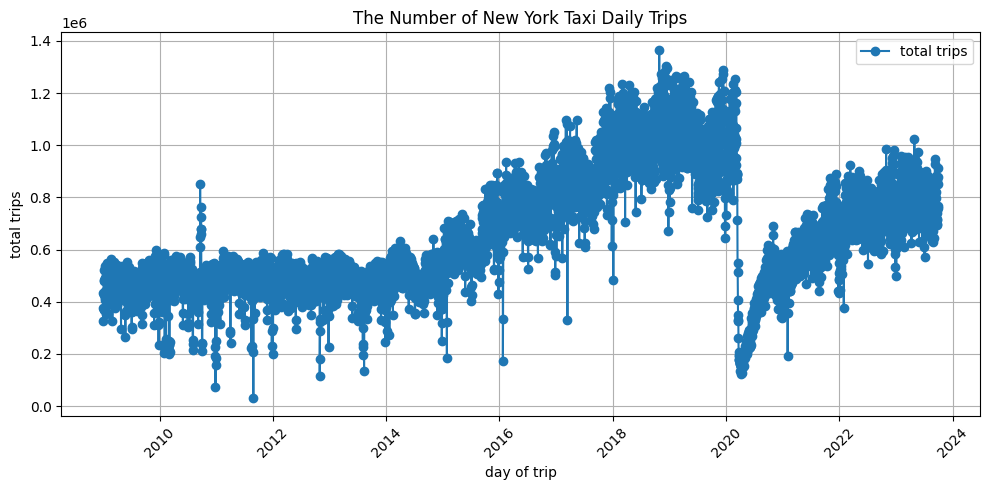

In [27]:
#--- Plotting Total Trips from 2009-2023 for All Vehicles---
# Ensure date is in datetime
data_total["day_of_trip"] = pd.to_datetime(data_total["day_of_trip"])

# Plot
plt.figure(figsize=(10,5))
plt.plot(data_total["day_of_trip"], data_total["total_trip"], marker="o", linestyle="-", label="total trips")

plt.title("The Number of New York Taxi Daily Trips")
plt.xlabel("day of trip")
plt.ylabel("total trips")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Total Monthly Taxi Trip in New York City

In [28]:
data_total.head()

,day_of_trip,total_trip_yellow,total_trip_green,total_trip_fhv,total_trip_hvfhv,total_trip
0,2009-01-01,327625,NaN,NaN,NaN,327625.0
1,2009-01-02,376708,NaN,NaN,NaN,376708.0
2,2009-01-03,432710,NaN,NaN,NaN,432710.0
3,2009-01-04,367525,NaN,NaN,NaN,367525.0
4,2009-01-05,370901,NaN,NaN,NaN,370901.0


In [29]:
data_total = data_total.set_index("day_of_trip")
monthly_trip = data_total.resample("ME").sum()
monthly_trip = monthly_trip.reset_index()
monthly_trip.head()

,day_of_trip,total_trip_yellow,total_trip_green,total_trip_fhv,total_trip_hvfhv,total_trip
0,2009-01-31,14092413,0.0,0.0,0.0,14092413.0
1,2009-02-28,13380122,0.0,0.0,0.0,13380122.0
2,2009-03-31,14387371,0.0,0.0,0.0,14387371.0
3,2009-04-30,14294783,0.0,0.0,0.0,14294783.0
4,2009-05-31,14796313,0.0,0.0,0.0,14796313.0


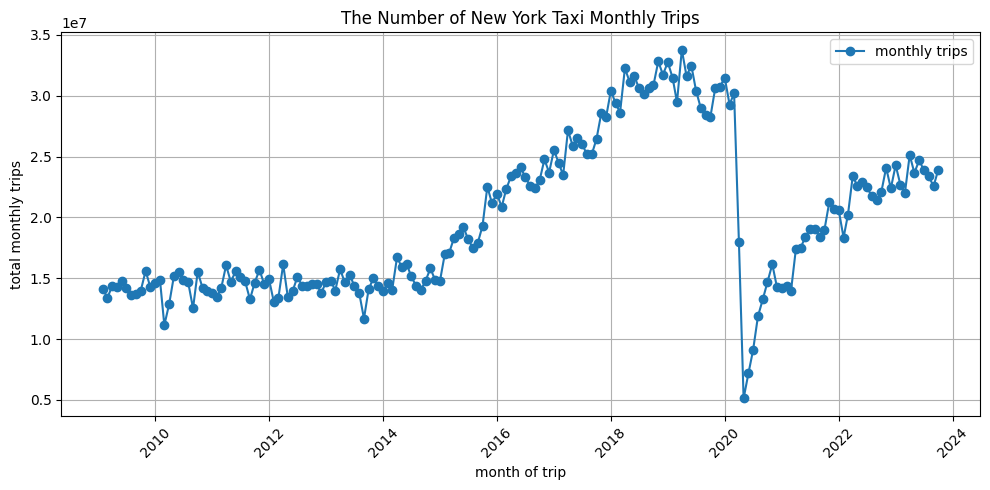

In [30]:
#--- Plotting Total Monthly Trips from 2009-2023 for All Vehicles---
# Ensure date is in datetime
monthly_trip["day_of_trip"] = pd.to_datetime(monthly_trip["day_of_trip"])

plt.figure(figsize=(10,5))
plt.plot(monthly_trip["day_of_trip"], monthly_trip["total_trip"], marker="o", linestyle="-", label="monthly trips")

plt.title("The Number of New York Taxi Monthly Trips")
plt.xlabel("month of trip")
plt.ylabel("total monthly trips")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
len(monthly_trip)

177